In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
print('[INFO] Using keras {0}'.format(keras.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import pandas as pd
#import statsmodels

import sys
import time

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)
nzones = 6

#infile = '../test2/histos_tba.8.npz'
#infile = '../test2/histos_tba.9.npz'
infile = '../test2/histos_tba.10.npz'

chsqfile = 'chsq.npz'


[INFO] Using numpy 1.12.1


Using Theano backend.


[INFO] Using keras 2.0.5
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3951218, 104)
[INFO] Loaded the parameters with shape (3951218, 3)


In [13]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 4) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_mask  = self.x_copy[:, nlayers*3:nlayers*4].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta, axis=1)
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Zones
      self.x_ieta  = self.x_road[:, 1].astype(np.int32)
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # use covariance
        with np.load(chsqfile) as loaded:
          self.x_cov = loaded['cov']
        nzones_to_scale = self.x_cov.shape[0]
        nvariables_to_scale = self.x_cov.shape[1]
        for zone in xrange(nzones_to_scale):
          ind = (self.x_ieta == zone)
          scale = self.x_cov[zone]
          self.x_copy[ind, :nvariables_to_scale] *= scale
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      else:
        x_theta_tmp = np.abs(self.x_theta) > 4.0
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      ## Something wrong with GE2/1?
      #bad_ge21 = 23
      #self.x_phi  [:, bad_ge21] = np.nan
      #self.x_theta[:, bad_ge21] = np.nan
      #self.x_bend [:, bad_ge21] = np.nan
      #self.x_mask [:, bad_ge21] = 1.0
      
      # Add variables: theta_median and mode variables
      self.x_theta_median -= 3  # scaled to [0,1]
      self.x_theta_median /= 83
      hits_to_station = np.array((5,5,1,1,1,2,2,2,2,3,3,4,4,1,1,2,3,3,3,4,4,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.float32)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_ieta(self):
    x_ieta = self.x_ieta.copy()
    return x_ieta

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']


In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=0)
x, y, w, x_mask, x_ieta = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_ieta()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_ieta_train, x_ieta_test = train_test_split(x, y, w, x_mask, x_ieta, test_size=0.3)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

[INFO] Using 81 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[-66.   0.   0. ...,   1.   1.   0.]
 [-33.   0.   0. ...,   1.   1.   1.]
 [  0.   0.  12. ...,   1.   1.   1.]
 ..., 
 [ 80.   0.   0. ...,   1.   1.   1.]
 [  0.  16.   0. ...,   1.   1.   1.]
 [  0.   0.  27. ...,   1.   1.   1.]] [-0.10976338 -0.03732378  0.04606546 ...,  0.1067722   0.11707978
  0.07033174] [ 1.54881692  1.18661892  1.23032737 ...,  1.53386092  1.58539891
  1.3516587 ]
[ -1.19085610e+00  -1.21589196e+00  -4.01284605e-01  -4.79933769e-01
   0.00000000e+00  -9.89201546e-01  -8.32545578e-01  -3.68177116e-01
  -4.21684414e-01  -1.45361686e+00  -9.67891157e-01  -1.25209439e+00
  -1.13908315e+00  -2.93622881e-01  -3.54723036e-01  -6.89572692e-01
  -1.20396805e+00  -7.18795061e-01  -2.69646466e-01  -1.05482411e+00
  -7.05577850e-01  -4.62560147e-01  -1.17156911e+00  -1.28328252e+00
   0.00000000e+00   1.75867423e-01   1.19646274e-01   6.74767867e-02
   9.07846633e-03   0.00000000e+00  -5.14894389e-02  -5.22443950e-02
   6.26996532e-03   3.24623957e-02  -1.85958609e-01 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.covariance import EmpiricalCovariance, MinCovDet

class ChiSquare(object):
  
  def __init__(self, x, x_mask, x_ieta, y):
    
    self.nentries = 40000 * 4
    self.nvariables = (nlayers * 3)
    self.nzones = nzones
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.x_ieta = x_ieta[:self.nentries]
    self.y = y[:self.nentries]
    #assert(self.x.shape == self.x_mask.shape)
    assert(self.x.shape[0] == self.x_ieta.shape[0])
    assert(self.x.shape[0] == self.y.shape[0])
    
    self.cov = np.ones((self.nzones,self.nvariables), dtype=np.float32)
    self.cov_1 = np.ones((self.nzones,self.nvariables), dtype=np.float32)
    self._find_covariance()
    

  def _find_covariance(self):
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        print('[INFO] Find covariance on zone {0} var {1}'.format(zone, i))
        
        lay = (i % nlayers)
        valid = (self.x_ieta == zone) & (~self.x_mask[:,lay])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        #print x_i, y_i
        
        if x_i.size == 0:
          continue
        if x_i.size < 400:
          print('[WARNING] Not enough statistics: {0}'.format(x_i.size))

        x_mean = np.mean(x_i)
        #x_i -= x_mean
        
        x_std = np.std(x_i)
        if x_std == 0.0:
          continue
        
        if (i < nlayers):
          # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
          # Minimum Covariance Determinant (MCD): robust estimator of covariance.
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
          self.cov[zone, i] = coef
          #print coef, mcd.covariance_
          print coef

          # Check with simple linear regression y = a * x
          lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
          coef = lr.coef_[0]
          self.cov_1[zone, i] = coef
          print lr.coef_[0]
        
        elif (nlayers) <= i < (nlayers*2):
          #p = np.percentile(x_i, [2,98])
          #coef = 1.0/(p[1] - p[0])
          coef = 1.0/4
          if 0 <= lay < 13:  # CSC
            pass
          elif lay < 22:  # RPC
            coef /= 4
          elif lay < 25:  # GEM
            coef /= 2
          else:
            assert(False)
          self.cov[zone, i] = coef
          self.cov_1[zone, i] = coef
          print coef
          
        elif (nlayers*2) <= i < (nlayers*3):
          # Check with simple linear regression y = a * x
          lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
          coef = lr.coef_[0]
          self.cov[zone, i] = coef
          self.cov_1[zone, i] = coef
          print coef
          
        else:
          assert(False)

  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    
    

In [10]:
chsq = ChiSquare(x_train, x_mask_train, x_ieta_train, y_train)
chsq.save_chsq('chsq.npz')
print('[INFO] ChiSquare is saved as chsq.npz')

[INFO] Find covariance on zone 0 var 0
[INFO] Find covariance on zone 0 var 1
[INFO] Find covariance on zone 0 var 2
0.00285887
0.00275619
[INFO] Find covariance on zone 0 var 3
0.00406942
0.00364113
[INFO] Find covariance on zone 0 var 4
[INFO] Find covariance on zone 0 var 5
[INFO] Find covariance on zone 0 var 6
[INFO] Find covariance on zone 0 var 7
-0.00720346
-0.00633831
[INFO] Find covariance on zone 0 var 8
-0.00787142
-0.00680686
[INFO] Find covariance on zone 0 var 9
[INFO] Find covariance on zone 0 var 10
-0.00581146
-0.00462073
[INFO] Find covariance on zone 0 var 11
[INFO] Find covariance on zone 0 var 12
-0.00389728
-0.00218818
[INFO] Find covariance on zone 0 var 13
0.00325225
0.0031118
[INFO] Find covariance on zone 0 var 14
0.00472633
0.00416845
[INFO] Find covariance on zone 0 var 15
-0.00236123
-0.00303992
[INFO] Find covariance on zone 0 var 16
[INFO] Find covariance on zone 0 var 17
[INFO] Find covariance on zone 0 var 18
-0.00441303
-0.00317051
[INFO] Find covaria

In [11]:
print chsq.cov

[[  1.00000000e+00   1.00000000e+00   2.85887392e-03   4.06942191e-03
    1.00000000e+00   1.00000000e+00   1.00000000e+00  -7.20345788e-03
   -7.87141547e-03   1.00000000e+00  -5.81145799e-03   1.00000000e+00
   -3.89727810e-03   3.25225107e-03   4.72633308e-03  -2.36122962e-03
    1.00000000e+00   1.00000000e+00  -4.41303430e-03   1.00000000e+00
    1.00000000e+00  -2.91102286e-03   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   2.50000000e-01
    2.50000000e-01   1.00000000e+00   1.00000000e+00   1.00000000e+00
    2.50000000e-01   2.50000000e-01   1.00000000e+00   2.50000000e-01
    1.00000000e+00   2.50000000e-01   6.25000000e-02   6.25000000e-02
    6.25000000e-02   1.00000000e+00   1.00000000e+00   6.25000000e-02
    1.00000000e+00   1.00000000e+00   6.25000000e-02   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.17074318e-01   1.16620414e-01   1.00000000e+00   1.00000000e+00
    1.00000000e+00  

In [14]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
x, y, w, x_mask, x_ieta = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_ieta()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_ieta_train, x_ieta_test = train_test_split(x, y, w, x_mask, x_ieta, test_size=0.3)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

[INFO] Using 81 variables and 1 parameters


(2765852, 81) (2765852,) (2765852, 25)
0 0.113012 [-0.20371757  0.19423656]
1 0.112899 [-0.20519618  0.19555575]
2 0.111003 [-0.20298004  0.19154455]
3 0.112054 [-0.22035404  0.19126283]
5 0.0747846 [-0.1507085   0.16506049]
6 0.0914104 [-0.1885282   0.19598119]
7 0.074487 [-0.14406916  0.18008645]
8 0.083547 [-0.15742831  0.19678539]
9 0.119222 [-0.25231394  0.26331866]
10 0.107546 [-0.22106743  0.24563047]
11 0.12384 [-0.26948494  0.28337464]
12 0.0953705 [-0.20577295  0.22829276]
13 0.110315 [-0.20441167  0.1849439 ]
14 0.107544 [-0.20795865  0.18905333]
15 0.0247247 [-0.04785772  0.04785772]
16 0.122156 [-0.25449955  0.27040577]
17 0.108061 [-0.2280184   0.24466956]
18 0.081341 [-0.15886924  0.19417351]
19 0.119027 [-0.26122734  0.27573997]
20 0.0916183 [-0.20434922  0.21636976]
21 0.0630977 [-0.13704833  0.1397291 ]
22 0.113909 [-0.20040379  0.19642052]
23 0.0527816 [-0.11132976  0.13293301]
25 0.194985 [-0.25  0.5 ]
26 0.181755 [-0.25  0.5 ]
27 0.171061 [-0.125  0.5  ]
28 0.15426

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-njopjo/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


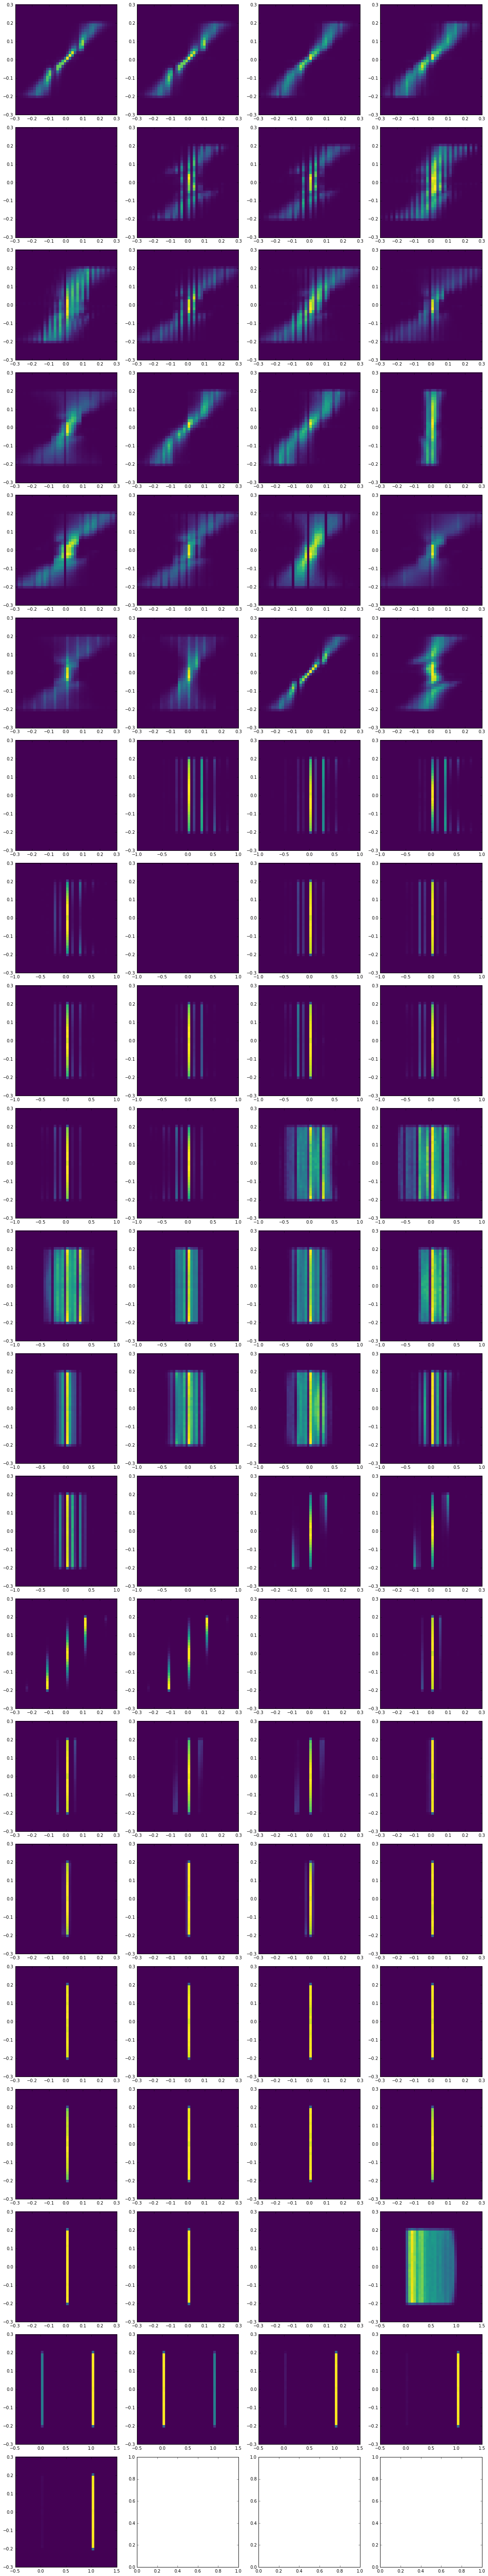

In [15]:
if True:
  print x_train.shape, y_train.shape, x_mask_train.shape

  fig, axs = plt.subplots(84/4, 4, figsize=(4*4,4*84/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    mask = x_mask_train[...,(i%25)]
    mask = mask.astype(np.bool)
    if i >= (nlayers*3):
      mask *= False

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -0.3, 0.3
    ymin, ymax = -0.3, 0.3
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -1, 1
    elif i == 75:
      xmin, xmax = -0.5, 1.5
    elif 76 <= i < 81:
      xmin, xmax = -0.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_train[...,i][~mask], y_train[~mask], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_train[...,i][~mask].size > 0:
      print i, np.std(x_train[...,i][~mask]), np.percentile(x_train[...,i][~mask], [2,98])

In [ ]:
########################## PLEASE IGNORE

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.covariance import EmpiricalCovariance, MinCovDet


class ChiSquare(object):
  
  def __init__(self, x, x_mask, x_ieta, y):
    
    self.nentries = 40000
    self.nvariables = 75
    self.nzones = 6
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.x_mask = np.tile(self.x_mask, 3)
    self.y = y[:self.nentries]
    self.x_ieta = x_ieta[:self.nentries]
    assert self.x.shape == self.x_mask.shape
    assert self.x.shape[0] == self.x_ieta.shape[0]
    assert self.x.shape[0] == self.y.shape[0]
    
    self.cov = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self._find_covariance()
    
    self.offset = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self.scale = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self._find_difference()
    
    
  def _find_covariance(self):
    
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        if i >= 25:
          continue
        
        print('[INFO] Find covariance on zone {0} var {1}'.format(zone, i))
                
        valid = (self.x_ieta == zone) & (~self.x_mask[:,i])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        #print x_i, y_i
        
        if x_i.size == 0:
          continue

        x_mean = np.mean(x_i)
        x_i -= x_mean
        
        x_std = np.std(x_i)
        if x_std == 0:
          continue

        # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
        # Minimum Covariance Determinant (MCD): robust estimator of covariance.
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
        self.cov[zone, i] = 1.0 / coef  # do the inverse
        print coef, mcd.covariance_
        
        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        print lr.intercept_, lr.coef_
        

  def _find_difference(self):
    
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        
        print('[INFO] Find difference on zone {0} var {1}'.format(zone, i))
        
        valid = (self.x_ieta == zone) & (~self.x_mask[:,i])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        
        if x_i.size == 0:
          continue
        
        coef = self.cov[zone, i]
        x_pred = y_i * coef  # use the inverse
        x_diff = x_i - x_pred
        
        quantile_range = (25.0, 50.0, 75.0)
        q = np.percentile(x_diff, quantile_range)
        self.offset[zone, i] = q[1]
        if q[2] > q[0]:
          self.scale[zone, i] = 1.0 / (q[2] - q[0])  # do the inverse
        else:
          self.scale[zone, i] = 1.0
        print q
        print np.mean(x_diff), np.std(x_diff)
        
        
  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, offset=self.offset, scale=self.scale)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.offset = loaded['offset']
    self.scale = loaded['scale']
    

In [ ]:
chsq = ChiSquare(x_train, x_mask_train, x_ieta_train, y_train)
chsq.save_chsq('chsq.npz')
print('[INFO] ChiSquare is saved as chsq.npz')

In [ ]:
yy = []
zz = []

for x, x_mask, zone, y in zip(x_train, x_mask_train, x_ieta_train, y_train[:1000]):
  
  x = x[:chsq.nvariables]
  x_mask = np.tile(x_mask, 3)
  valid = ~x_mask
  
  coef = chsq.cov[zone]
  offset = chsq.offset[zone]
  scale = chsq.scale[zone]
  
  x_pred = y * coef
  #print x, x_pred
  
  x_diff = (x_pred - x - offset) 
  x_diff *= scale  # use the inverse
  x_diff **= 2
  
  x_diff = x_diff[valid]
  #x_diff = np.sort(x_diff)[::-1]  # sort descending
  x_diff[::-1].sort()  # sort descending in-place
  x_diff = x_diff[:3]
  
  z = x_diff.sum()
  yy.append(y)
  zz.append(z)
  
  

In [ ]:
_ = plt.hist(zz, bins=40, range=[0,50])

In [ ]:
_ = plt.hist2d(zz, yy, bins=40, range=[[0,50],[-0.2,0.2]])